# ++++++++++++++++++++ Preprocessing ++++++++++++++++++++

## Packet Inspection

### LOAD DATA

In [1]:
import pandas as pd
def load_data(name, is_display=False):
    '''Given a filename the loads the csv data into a pandas dataframe, and removes redudant features
    It returns the pandas dataframe'''
    df= pd.read_csv(name)               # Load CSV data into Pandas Dataframe
    indices = df[df['Protocol'] != 'Modbus/TCP'].index  # Find any rows that aren't the Modbus/TCP interactions
    df = df.drop(index =indices)        # Remove non-Modbus interactions
    df = df.drop(columns=['No.', 'Length', 'Source', 'Destination','Protocol'])       # Drop Redundant Index Column
    if is_display:
        display(df.head(3))                 # Show first 5 packets
    return df

In [2]:
norm_df    = load_data('Normal Activity.csv', True)  # Load Normal Data
attack_df = load_data('Attack.csv', True)          # Load Attack Data

,Time,Info
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ..."
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ..."
2,0.001151,"Query: Trans: 15773; Unit: 1, Func: 2: ..."


,Time,Info
0,0.000000,"Query: Trans: 13010; Unit: 1, Func: 2: ..."
1,0.001266,"Response: Trans: 13010; Unit: 1, Func: 2: ..."
2,0.001792,"Query: Trans: 13011; Unit: 1, Func: 5: ..."


### DETERMINE PACKET FREQUENCY (ELAPSED TIME)

In [3]:
def get_freq(df,is_display=False):
    '''Given the Time feature, we determine the time elapsed between each packet.
    We add this elapsed time information as a new feature to dataframe.'''
    time_data= df['Time'].values            # Get Time column and put into a list
    packet_freq = [time_data[idx+1]-time_data[idx] for idx in range(len(time_data)-1)]+[0] # Calculate time difference between packets
    df['Packet Frequency'] = packet_freq    # Set Packet Frequency as a Column
    if is_display:
        display(df.head())                      # Show first 5 packets

In [4]:
get_freq(norm_df, True)     # Normal Activity
get_freq(attack_df, True)  # Attack 1 Data

,Time,Info,Packet Frequency
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ...",0.000571
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ...",0.000580
2,0.001151,"Query: Trans: 15773; Unit: 1, Func: 2: ...",0.001111
3,0.002262,"Response: Trans: 15773; Unit: 1, Func: 2: ...",0.000605
4,0.002867,"Query: Trans: 15774; Unit: 1, Func: 2: ...",0.000992


,Time,Info,Packet Frequency
0,0.000000,"Query: Trans: 13010; Unit: 1, Func: 2: ...",0.001266
1,0.001266,"Response: Trans: 13010; Unit: 1, Func: 2: ...",0.000526
2,0.001792,"Query: Trans: 13011; Unit: 1, Func: 5: ...",0.001369
3,0.003161,"Response: Trans: 13011; Unit: 1, Func: 5: ...",0.000546
4,0.003707,"Query: Trans: 13012; Unit: 1, Func: 5: ...",0.001447


#### Show packet frequency

In [5]:
def show_freq(df,df2):
    '''Displays the Packet Frequency/Elapsed time for three datasets  using a 
    histogram (e.g. normal data, attack 1, attack 2 )'''
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize = (10, 5))
    ax = fig.add_axes([1,1,1,1])
    left,right = ax.set_xlim([0,0.0025])
    df['Packet Frequency'].hist(bins=400, color='red', alpha=0.3, label = 'Normal Data')
    df2['Packet Frequency'].hist(bins=400, color='blue', alpha=0.3, label = 'Attack')
    plt.xlabel('Packet Frequency')
    plt.ylabel('Number of Packets')
    plt.legend()
    plt.title('Packet Frequency Histogram')
    plt.show()  # Display a histogram of the Packet Frequency

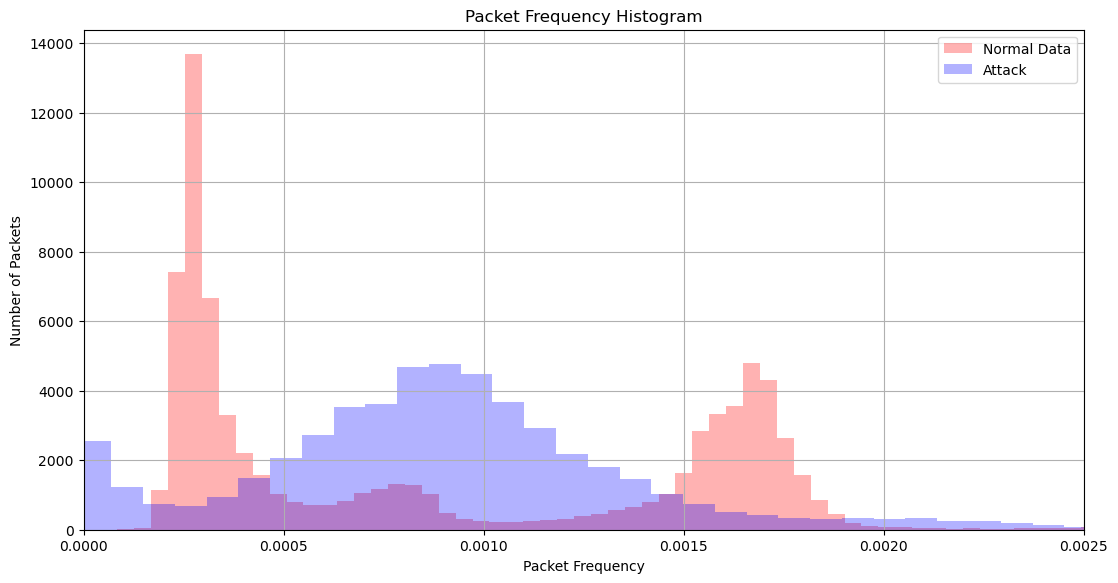

In [6]:
show_freq(norm_df, attack_df)

We see there is more delay in normal data than in malicious data

### Separate Info Column Into Multiple Columns

In [7]:
def get_query_or_response(data, is_display=False):
    '''This method parses the Info Feature for function number, unit code, transaction number, type of 
    operation, whether or not it is a query or response. Then it adds these as independent features to
    the dataframe. It also extracts if there are two write single coil Queries in a row, and adds it as 
    a feature to the dataframe.'''
    info = data['Info'].values
    q_or_r = []
    operation = []
    func= []
    unit = []
    trans = []
    double_write = []
    for idx in range(len(info)):
        info_str = info[idx]
        string = info_str.strip(': ')
        string = string.split(': ')
        string = [value.split(',')[0] for value in string]
        new_string = [value.split(';')[0] for value in string] 
        #================ IF ITS A QUERY OR RESPONSE ====================#
        if info_str.find('Query') != -1:
            q_or_r.append(1)
        elif info_str.find('Response') != -1:
            q_or_r.append(0)
        else:
            q_or_r.append(-1)
        #================= TYPE OF OPERATION ============================#
        operation.append(new_string[-1])
        
    # Create a new feature
    data['Is Query'] = q_or_r
    data['Operation'] = operation
    
    #============== DOUBLE Query ========================#
    for idx in range(len(data)-1):
        query_data = data['Is Query'].values
        if query_data[idx+1] == 1 and query_data[idx] == 1:
            double_write.append(1)
        else:
            double_write.append(0)
    # Create a new feature
    data['Double Query'] = double_write +[0]
    if is_display:
        indices = list(data[data['Double Query']==1].index)
        if indices == []:
            display(data.head(10))
        else:
            first_index = indices[3]
            display(data.iloc[first_index:first_index+10])

In [8]:
get_query_or_response(norm_df, True)
get_query_or_response(attack_df, True)

,Time,Info,Packet Frequency,Is Query,Operation,Double Query
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ...",0.000571,1,Write Single Coil,0
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ...",0.000580,0,Write Single Coil,0
2,0.001151,"Query: Trans: 15773; Unit: 1, Func: 2: ...",0.001111,1,Read Discrete Inputs,0
3,0.002262,"Response: Trans: 15773; Unit: 1, Func: 2: ...",0.000605,0,Read Discrete Inputs,0
4,0.002867,"Query: Trans: 15774; Unit: 1, Func: 2: ...",0.000992,1,Read Discrete Inputs,0
5,0.003859,"Response: Trans: 15774; Unit: 1, Func: 2: ...",0.000428,0,Read Discrete Inputs,0
6,0.004287,"Query: Trans: 15775; Unit: 1, Func: 5: ...",0.002808,1,Write Single Coil,0
7,0.007095,"Response: Trans: 15775; Unit: 1, Func: 5: ...",0.000679,0,Write Single Coil,0
8,0.007774,"Query: Trans: 15776; Unit: 1, Func: 5: ...",0.001114,1,Write Single Coil,0
9,0.008888,"Response: Trans: 15776; Unit: 1, Func: 5: ...",0.000593,0,Write Single Coil,0


,Time,Info,Packet Frequency,Is Query,Operation,Double Query
26640,37.958847,"Query: Trans: 26319; Unit: 1, Func: 5: ...",0.000611,1,Write Single Coil,1
26641,37.959458,"Query: Trans: 8; Unit: 1, Func: 5: ...",0.001205,1,Write Single Coil,0
26642,37.960663,"Response: Trans: 26319; Unit: 1, Func: 5: ...",0.000009,0,Write Single Coil,0
26643,37.960672,"Response: Trans: 8; Unit: 1, Func: 5: ...",0.000517,0,Write Single Coil,0
26644,37.961189,"Query: Trans: 26320; Unit: 1, Func: 5: ...",0.000438,1,Write Single Coil,1
26645,37.961627,"Query: Trans: 9; Unit: 1, Func: 5: ...",0.000033,1,Write Single Coil,0
26646,37.961660,"Response: Trans: 26320; Unit: 1, Func: 5: ...",0.000489,0,Write Single Coil,0
26647,37.962149,"Query: Trans: 26321; Unit: 1, Func: 2: ...",0.001426,1,Read Discrete Inputs,0
26648,37.963575,"Response: Trans: 9; Unit: 1, Func: 5: ...",0.000097,0,Write Single Coil,0
26649,37.963672,"Response: Trans: 26321; Unit: 1, Func: 2: ...",0.000460,0,Read Discrete Inputs,0


### One Hot Encode Operation  Features

In [9]:
def one_hot(df):
    return pd.get_dummies(df, columns=['Operation'])

In [10]:
norm_df.head()

,Time,Info,Packet Frequency,Is Query,Operation,Double Query
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ...",0.000571,1,Write Single Coil,0
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ...",0.000580,0,Write Single Coil,0
2,0.001151,"Query: Trans: 15773; Unit: 1, Func: 2: ...",0.001111,1,Read Discrete Inputs,0
3,0.002262,"Response: Trans: 15773; Unit: 1, Func: 2: ...",0.000605,0,Read Discrete Inputs,0
4,0.002867,"Query: Trans: 15774; Unit: 1, Func: 2: ...",0.000992,1,Read Discrete Inputs,0


In [11]:
norm_df = one_hot(norm_df)
attack_df = one_hot(attack_df)

In [12]:
display(norm_df.head(2))

,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Read Discrete Inputs,Operation_Write Single Coil
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ...",0.000571,1,0,0,1
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ...",0.000580,0,0,0,1


### Drop Useless Features

In [13]:
useless = ['Operation_Read Discrete Inputs'] 
norm_df = norm_df.drop(columns=useless)
attack_df = attack_df.drop(columns=useless)

In [14]:
display(norm_df.head(5))
display(attack_df.head(5))

,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ...",0.000571,1,0,1
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ...",0.000580,0,0,1
2,0.001151,"Query: Trans: 15773; Unit: 1, Func: 2: ...",0.001111,1,0,0
3,0.002262,"Response: Trans: 15773; Unit: 1, Func: 2: ...",0.000605,0,0,0
4,0.002867,"Query: Trans: 15774; Unit: 1, Func: 2: ...",0.000992,1,0,0


,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil
0,0.000000,"Query: Trans: 13010; Unit: 1, Func: 2: ...",0.001266,1,0,0
1,0.001266,"Response: Trans: 13010; Unit: 1, Func: 2: ...",0.000526,0,0,0
2,0.001792,"Query: Trans: 13011; Unit: 1, Func: 5: ...",0.001369,1,0,1
3,0.003161,"Response: Trans: 13011; Unit: 1, Func: 5: ...",0.000546,0,0,1
4,0.003707,"Query: Trans: 13012; Unit: 1, Func: 5: ...",0.001447,1,0,1


### Determine Class Labels

Given that the Source and Destination is exactly 50% (due to query/response set up) in the normal data, we can abstract this to find perhaps a more interesting pattern. Namely, if there are 2 queries in a row, this might indicate a benign and malicious sender are both sending, since normally we have a benign call the benign response. Thus, I will make another feature to determine if there are two queries in a row (or two response in a row) or not. 

In [15]:
def label(data):
    # Both Attacks Are Based on Writing to a Coil to Turn it on or off
    indices = list(data[data['Double Query'] == 1].index.values)
    indices.extend([idx+1 for idx in indices])
    
    is_query= data['Is Query']
    op   = data['Operation_Write Single Coil']
    freq = data['Packet Frequency']

    
    class_labels = ['Benign']*len(data)
    for idx in indices:
        try :
            if (is_query.iloc[idx] ==1) and (is_query.iloc[idx+1] == 1): # Double Query
                if (op.iloc[idx+1] == 1) and (op.iloc[idx] ==0): # If second query is writing to a coil: 
                    class_labels[idx+1] = 'Malicious' # Second Query is bad
                elif op.iloc[idx+1] == 0 and op.iloc[idx] ==1:  # If first query is writing to a coil:
                    class_labels[idx] = 'Malicious' # First Query is bad
                elif op.iloc[idx+1]==1 and op.iloc[idx]==1: # Two write single coul operations in a row:
                    if freq.iloc[idx] <= freq.iloc[idx+1]:   #if both are write operations and queries
                        class_labels[idx] = 'Malicious'      # we choose the faster freq as the malicious packet
                    else:
                        class_labels[idx+1] = 'Malicious'
                else: # Neither are writes
                    continue
        except:
            continue

    #Create a new feature
    data['Class'] = class_labels
   
    indices = list(data[data['Double Query']==1].index)
    if indices == []:
        display(data.head(10))
    else:
        first_index = indices[3]
        display(data.iloc[first_index:first_index+10])

In [16]:
label(norm_df)
label(attack_df)

,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil,Class
0,0.000000,"Query: Trans: 15772; Unit: 1, Func: 5: ...",0.000571,1,0,1,Benign
1,0.000571,"Response: Trans: 15772; Unit: 1, Func: 5: ...",0.000580,0,0,1,Benign
2,0.001151,"Query: Trans: 15773; Unit: 1, Func: 2: ...",0.001111,1,0,0,Benign
3,0.002262,"Response: Trans: 15773; Unit: 1, Func: 2: ...",0.000605,0,0,0,Benign
4,0.002867,"Query: Trans: 15774; Unit: 1, Func: 2: ...",0.000992,1,0,0,Benign
5,0.003859,"Response: Trans: 15774; Unit: 1, Func: 2: ...",0.000428,0,0,0,Benign
6,0.004287,"Query: Trans: 15775; Unit: 1, Func: 5: ...",0.002808,1,0,1,Benign
7,0.007095,"Response: Trans: 15775; Unit: 1, Func: 5: ...",0.000679,0,0,1,Benign
8,0.007774,"Query: Trans: 15776; Unit: 1, Func: 5: ...",0.001114,1,0,1,Benign
9,0.008888,"Response: Trans: 15776; Unit: 1, Func: 5: ...",0.000593,0,0,1,Benign


,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil,Class
26640,37.958847,"Query: Trans: 26319; Unit: 1, Func: 5: ...",0.000611,1,1,1,Malicious
26641,37.959458,"Query: Trans: 8; Unit: 1, Func: 5: ...",0.001205,1,0,1,Benign
26642,37.960663,"Response: Trans: 26319; Unit: 1, Func: 5: ...",0.000009,0,0,1,Benign
26643,37.960672,"Response: Trans: 8; Unit: 1, Func: 5: ...",0.000517,0,0,1,Benign
26644,37.961189,"Query: Trans: 26320; Unit: 1, Func: 5: ...",0.000438,1,1,1,Benign
26645,37.961627,"Query: Trans: 9; Unit: 1, Func: 5: ...",0.000033,1,0,1,Malicious
26646,37.961660,"Response: Trans: 26320; Unit: 1, Func: 5: ...",0.000489,0,0,1,Benign
26647,37.962149,"Query: Trans: 26321; Unit: 1, Func: 2: ...",0.001426,1,0,0,Benign
26648,37.963575,"Response: Trans: 9; Unit: 1, Func: 5: ...",0.000097,0,0,1,Benign
26649,37.963672,"Response: Trans: 26321; Unit: 1, Func: 2: ...",0.000460,0,0,0,Benign


Based on the correlation matrix, we can see that there is a strong relationship between length and double query/response for normal activity, but a weak relationship between the two for malicious activity.  

In [17]:
norm_df.corr()

,Time,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil
Time,1.000000,-0.024754,-3.329374e-05,NaN,4.149865e-05
Packet Frequency,-0.024754,1.000000,6.937999e-01,NaN,-2.833894e-02
Is Query,-0.000033,0.693800,1.000000e+00,NaN,-6.622373e-18
Double Query,NaN,NaN,NaN,NaN,NaN
Operation_Write Single Coil,0.000041,-0.028339,-6.622373e-18,NaN,1.000000e+00


In [18]:
norm_df['Class'].value_counts()

Benign    81946
Name: Class, dtype: int64

# ++++++++++++++++++++ DETECTION ++++++++++++++++++++

###  Offline Intrusion Detection System

In [19]:
def offline_IDS(filename):
    '''This offline IDS takes in a filename, preprocesses it and then classifies the packets 
    as Benign or Malicious and displays its predictions
    Takes a filename and preprocesses the csv data into the correct format of a pandas dataframe'''
    df = load_data(filename)
    get_freq(df)
    get_query_or_response(df, False)
    df = one_hot(df)
    df = df.drop(columns = ['Operation_Read Discrete Inputs'] )
    label(df)
    return df

In [20]:
def check_time(df):
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize = (10, 5))
    #ax = fig.add_axes([1,1,1,1])
    #left,right = ax.set_xlim([0,0.0025])
    indices = list(df[df['Class'] == 'Malicious'].index)  # Where it predicts malicious
    mal_df = df.loc[indices] 
    mal_df['Time'].hist(bins=400, color='red', alpha=0.3, label = 'Malicious Data')
    plt.xlabel('Time')
    plt.ylabel('Number of Packets')
    plt.legend()
    plt.title('Predict Malicious Packet Timestamps')
    plt.show()  # Display a histogram of t

## Attack Data 1: No Time Delay
- Start: 38 seconds
- Ends: 57 seconds

,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil,Class
26640,37.958847,"Query: Trans: 26319; Unit: 1, Func: 5: ...",0.000611,1,1,1,Malicious
26641,37.959458,"Query: Trans: 8; Unit: 1, Func: 5: ...",0.001205,1,0,1,Benign
26642,37.960663,"Response: Trans: 26319; Unit: 1, Func: 5: ...",0.000009,0,0,1,Benign
26643,37.960672,"Response: Trans: 8; Unit: 1, Func: 5: ...",0.000517,0,0,1,Benign
26644,37.961189,"Query: Trans: 26320; Unit: 1, Func: 5: ...",0.000438,1,1,1,Benign
26645,37.961627,"Query: Trans: 9; Unit: 1, Func: 5: ...",0.000033,1,0,1,Malicious
26646,37.961660,"Response: Trans: 26320; Unit: 1, Func: 5: ...",0.000489,0,0,1,Benign
26647,37.962149,"Query: Trans: 26321; Unit: 1, Func: 2: ...",0.001426,1,0,0,Benign
26648,37.963575,"Response: Trans: 9; Unit: 1, Func: 5: ...",0.000097,0,0,1,Benign
26649,37.963672,"Response: Trans: 26321; Unit: 1, Func: 2: ...",0.000460,0,0,0,Benign


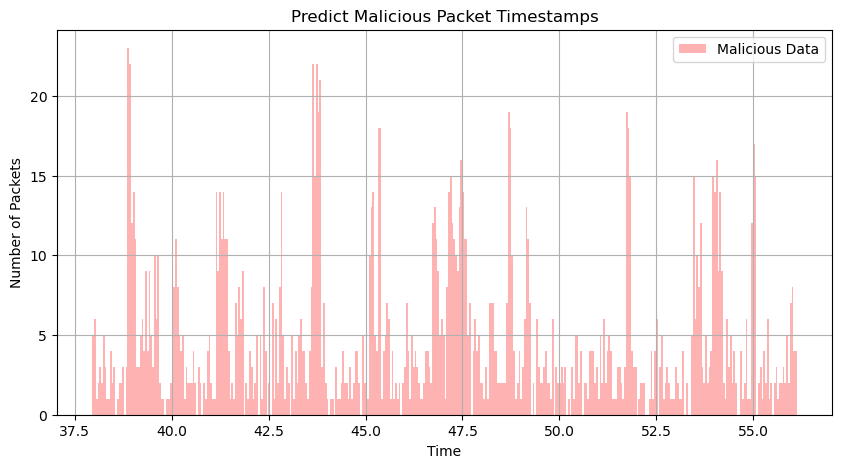

In [21]:
df = offline_IDS('Attack.csv')
check_time(df)

### ======================== Attacks with Delay ======================== 

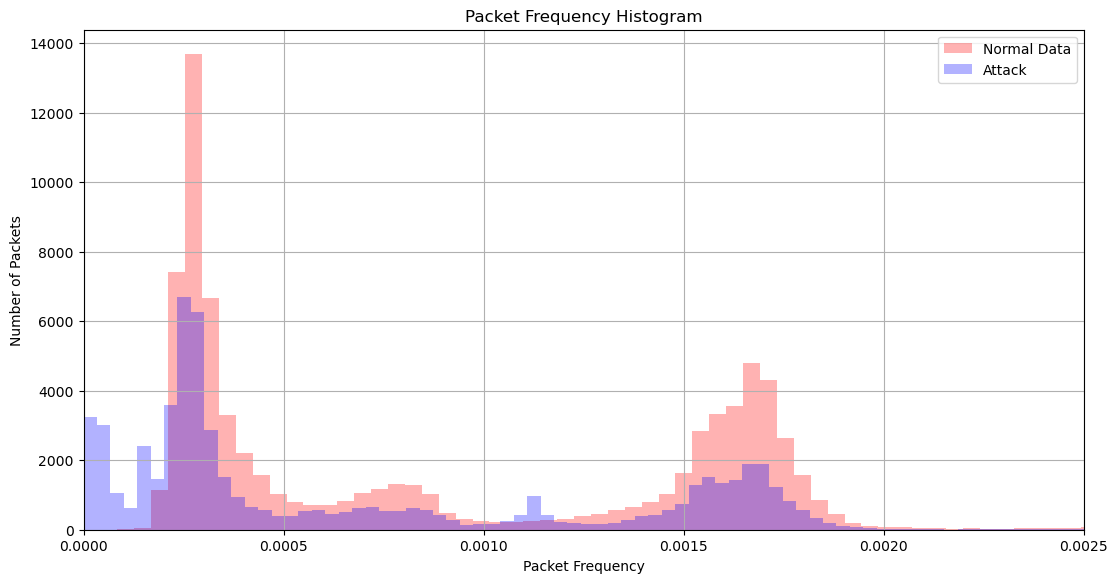

In [22]:
attack_delay = load_data('Attack_Delay.csv')
get_freq(attack_delay)
show_freq(norm_df, attack_delay)

# Attack 1: Time Delay
- Start : 21
- End 36

,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil,Class
21566,20.752682,"Response: Trans: 5; Unit: 1, Func: 5: ...",0.000028,0,0,1,Benign
21567,20.752710,"Response: Trans: 14461; Unit: 1, Func: 2: ...",0.000263,0,0,0,Benign
21568,20.752973,"Query: Trans: 14462; Unit: 1, Func: 2: ...",0.001586,1,0,0,Benign
21569,20.754559,"Response: Trans: 14462; Unit: 1, Func: 2: ...",0.000012,0,0,0,Benign
21570,20.754571,"Query: Trans: 6; Unit: 1, Func: 5: ...",0.000206,1,1,1,Benign
21571,20.754777,"Query: Trans: 14463; Unit: 1, Func: 5: ...",0.001808,1,0,1,Benign
21572,20.756585,"Response: Trans: 6; Unit: 1, Func: 5: ...",0.000042,0,0,1,Benign
21573,20.756627,"Response: Trans: 14463; Unit: 1, Func: 5: ...",0.000236,0,0,1,Benign
21574,20.756863,"Query: Trans: 14464; Unit: 1, Func: 5: ...",0.000164,1,1,1,Benign
21575,20.757027,"Query: Trans: 7; Unit: 1, Func: 5: ...",0.001502,1,0,1,Benign


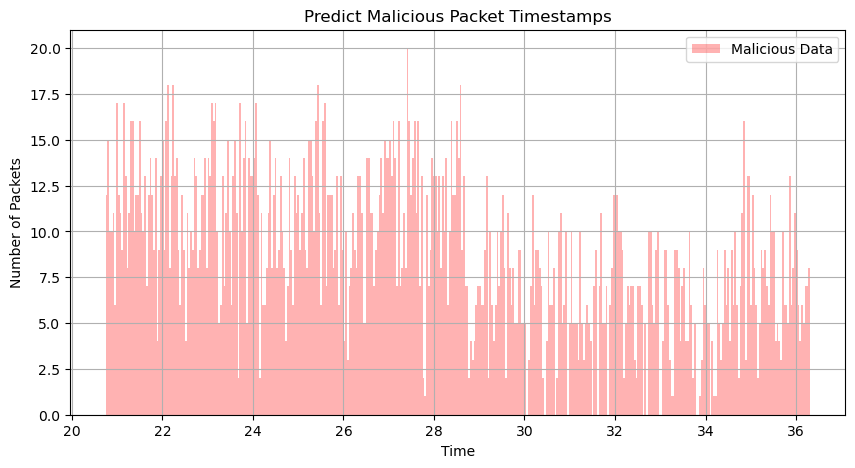

In [23]:
df = offline_IDS('Attack_Delay.csv')
check_time(df)


In [24]:
display(df[df['Time']>22].head(21))

,Time,Info,Packet Frequency,Is Query,Double Query,Operation_Write Single Coil,Class
24064,22.001132,"Response: Trans: 599; Unit: 1, Func: 5: ...",0.000054,0,0,1,Benign
24065,22.001186,"Response: Trans: 15116; Unit: 1, Func: 5: ...",0.000373,0,0,1,Benign
24066,22.001559,"Query: Trans: 15117; Unit: 1, Func: 2: ...",0.001064,1,1,0,Benign
24067,22.002623,"Query: Trans: 600; Unit: 1, Func: 5: ...",0.000430,1,0,1,Malicious
24068,22.003053,"Response: Trans: 600; Unit: 1, Func: 5: ...",0.000031,0,0,1,Benign
24069,22.003084,"Response: Trans: 15117; Unit: 1, Func: 2: ...",0.000209,0,0,0,Benign
24070,22.003293,"Query: Trans: 15118; Unit: 1, Func: 2: ...",0.000149,1,1,0,Benign
24071,22.003442,"Query: Trans: 601; Unit: 1, Func: 5: ...",0.001668,1,0,1,Malicious
24072,22.005110,"Response: Trans: 601; Unit: 1, Func: 5: ...",0.000027,0,0,1,Benign
24073,22.005137,"Response: Trans: 15118; Unit: 1, Func: 2: ...",0.000240,0,0,0,Benign
